In [1]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from behavenet.fitting.utils import get_output_dirs
from behavenet.fitting.utils import get_output_session_dir
from behavenet.fitting.utils import get_best_model_version
from behavenet.fitting.utils import get_lab_example
from behavenet.fitting.utils import read_session_info_from_csv
from behavenet.fitting.utils import find_session_dirs

results_dir = '/home/mattw/results/behavenet_figs/multisession-ae'
save_outputs = False

## 0. Plot train/val losses as a function of epochs/dataset
For AEs fit on multiple sessions

In [16]:
hparams = {
    'data_dir': '/home/mattw/data',  # might be a different path than what is saved in hparams
    'tt_save_path': '/home/mattw/results/behavenet',
    'experiment_name': 'test_pt',
    'model_class': 'ae',
    'n_ae_latents': 16,
    'lab': 'musall',
    'expt': 'vistrained',
    'animal': 'all',
    'session': 'all',
    'multisession': 1}
model_type = 'conv'

metrics_df = []

hparams['model_type'] = model_type   
hparams['session_dir'], _ = get_output_session_dir(hparams)
_, expt_dir = get_output_dirs(hparams)
model_version = get_best_model_version(expt_dir)
metric_file = os.path.join(expt_dir, model_version[0], 'metrics.csv')
metrics = pd.read_csv(metric_file)

sess_ids = read_session_info_from_csv(os.path.join(
    expt_dir, model_version[0], 'session_info.csv'))
sess_ids_strs = []
for sess_id in sess_ids:
    sess_ids_strs.append(str('%s/%s' % (sess_id['animal'], sess_id['session'])))
    
for i, row in metrics.iterrows():
    dataset = 'all' if row['dataset'] == -1 else sess_ids_strs[row['dataset']]
    metrics_df.append(pd.DataFrame({
        'dataset': dataset,
        'epoch': row['epoch'],
        'loss': row['val_loss'],
        'dtype': 'val',
        'model_type': model_type,
    }, index=[0]))
    metrics_df.append(pd.DataFrame({
        'dataset': dataset,
        'epoch': row['epoch'],
        'loss': row['tr_loss'],
        'dtype': 'train',
        'model_type': model_type,
    }, index=[0]))
    if 'test_loss' in row:
        metrics_df.append(pd.DataFrame({
            'dataset': dataset,
            'epoch': row['epoch'],
            'loss': row['test_loss'],
            'dtype': 'test',
            'model_type': model_type,
        }, index=[0]))
metrics_df = pd.concat(metrics_df)    

### plot validation data for ind/comb datasets as a function of epochs

In [12]:
save_outputs = True

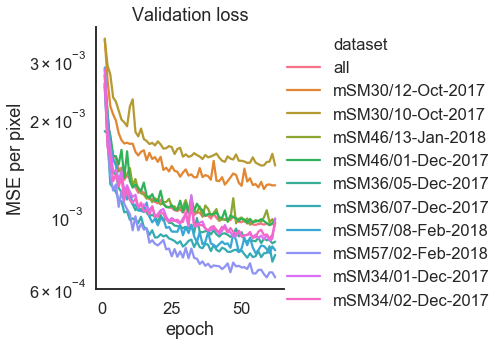

In [17]:
sns.set_style('white')
sns.set_context('talk')

# data_queried = metrics[~pd.notna(metrics.test_loss)]
data_queried = metrics_df[
    (metrics_df.dtype=='val') &
    (metrics_df.epoch>0) & 
    ~pd.isna(metrics_df.loss)]

y_axis = 'loss' # 'test_loss' | 'test_r2'
plot_type = 'line'
hue = 'dataset'
x_axis = 'epoch' # 'layers' | 'layer_size' | 'pred' | 'lags'

splt = sns.relplot(
    x=x_axis, y=y_axis, hue=hue, kind=plot_type, data=data_queried)
splt.ax.set_yscale('log')
splt.ax.set_ylabel('MSE per pixel')
#     splt.ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#     splt.ax.ticklabel_format(axis='y', style='sci', scilimits=(1, 2))  # (1, 2) a hack
#     splt._legend.set_title('Model\ntype')
    
plt.title('Validation loss')
if save_outputs:
    save_file = os.path.join(
        results_dir, 
        str('%s_%02i-dim_%s' % (hparams['lab'], hparams['n_ae_latents'], hparams['animal'])))
else:
    save_file = None
    
if save_file is not None:
    plt.savefig(save_file + '.jpg', dpi=300, format='jpeg')   
    
plt.show()

# 1. Plot val losses for different networks
These cells can be used to compare validation loss of a single session when using an ae trained specifically on that session, on all sessions from one animal, on all sessions from one experiment, etc.

### load results from all models

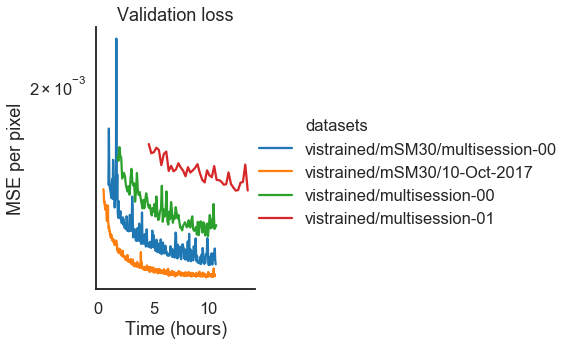

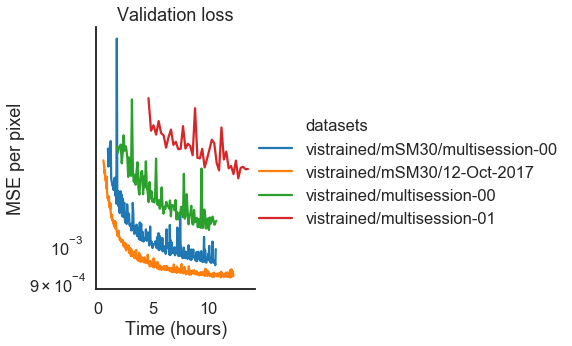

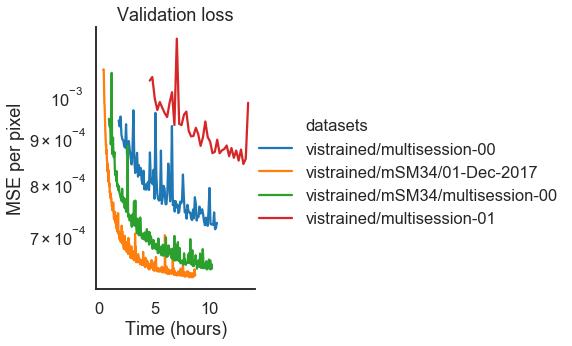

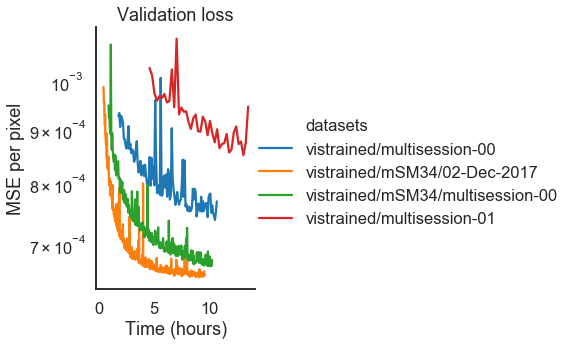

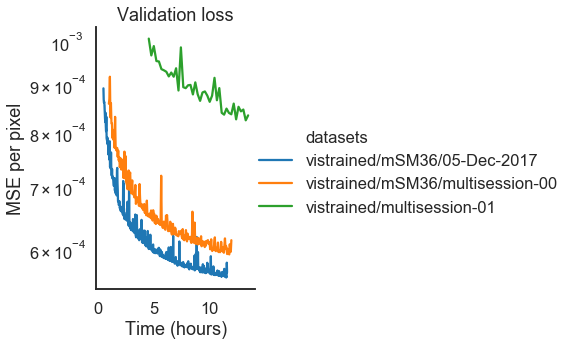

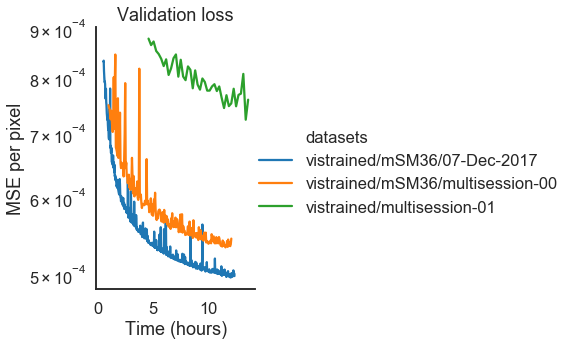

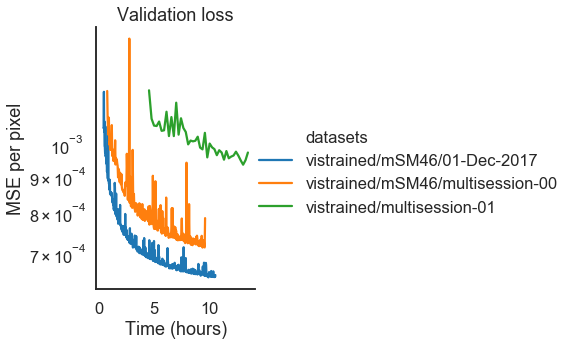

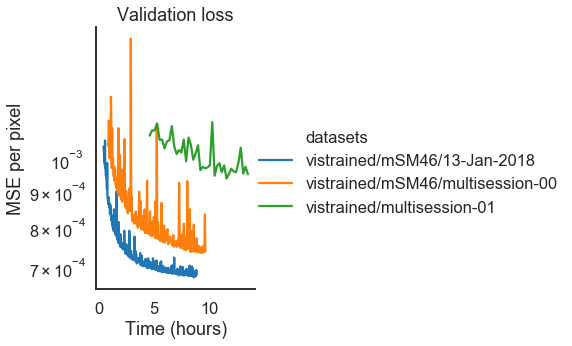

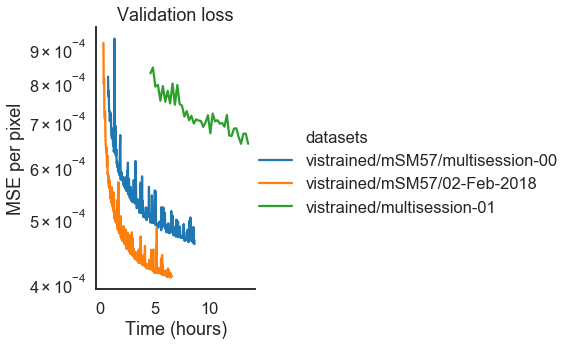

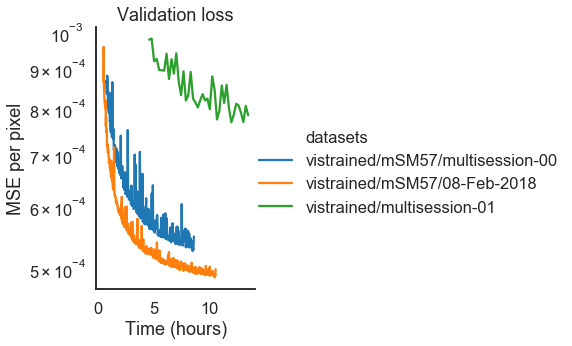

In [37]:
hparams = {
    'data_dir': '/home/mattw/data',  # might be a different path than what is saved in hparams
    'tt_save_path': '/home/mattw/results/behavenet',
    'experiment_name': 'test_pt',
    'model_class': 'ae',
    'n_ae_latents': 16,
    'lab': 'musall',
    'expt': 'vistrained',
    'animal': None,
    'session': None}
an_sess = [
    ('mSM30', '10-Oct-2017'),
    ('mSM30', '12-Oct-2017'),
    ('mSM34', '01-Dec-2017'),
    ('mSM34', '02-Dec-2017'),
    ('mSM36', '05-Dec-2017'),
    ('mSM36', '07-Dec-2017'),
    ('mSM46', '01-Dec-2017'),
    ('mSM46', '13-Jan-2018'),
    ('mSM57', '02-Feb-2018'),
    ('mSM57', '08-Feb-2018')]

for animal, session in an_sess:
    
    # load all ae models that used this session for fitting
    hparams['animal'] = animal
    hparams['session'] = session
    model_types = ['conv'] #['conv', 'linear']

    ids = {s: hparams[s] for s in ['lab', 'expt', 'animal', 'session']}
    session_dirs, session_strs = find_session_dirs(hparams)
    metrics_df = []
    for session_dir, session_str in zip(session_dirs, session_strs):
        hparams['session_dir'] = session_dir
        for model_type in model_types:

            hparams['model_type'] = model_type   
            _, expt_dir = get_output_dirs(hparams)
            model_version = get_best_model_version(expt_dir)
            metric_file = os.path.join(expt_dir, model_version[0], 'metrics.csv')
            metrics = pd.read_csv(metric_file)

            # get dataset index
            if session_dir.find('multi') > -1:
                sess_ids = read_session_info_from_csv(os.path.join(
                    expt_dir, model_version[0], 'session_info.csv'))
                dataset = None
                for i, sess_id in enumerate(sess_ids):
                    sess_id.pop('tt_save_path', None)
                    if sess_id == ids:
                        dataset = i
                if dataset is None:
                    raise Exception            
            else:
                dataset = 0

            first_timestamp = None
            for i, row in metrics.iterrows():

                # just get dataset we're interested in if a multi-session
                if session_dir.find('multi') > -1 and row['dataset'] != dataset:
                    continue

                if first_timestamp is None:
                    first_timestamp = pd.to_datetime(row['created_at'])

                elapsed_time = pd.to_datetime(row['created_at']) - first_timestamp
                elapsed_time_h = elapsed_time.seconds / 3600  # to hours
                metrics_df.append(pd.DataFrame({
                    'datasets': session_str,
                    'epoch': row['epoch'],
                    'time': elapsed_time_h,
                    'loss': row['val_loss'],
                    'dtype': 'val',
                    'model_type': model_type,
                }, index=[0]))
                metrics_df.append(pd.DataFrame({
                    'datasets': session_str,
                    'epoch': row['epoch'],
                    'time': elapsed_time_h,
                    'loss': row['tr_loss'],
                    'dtype': 'train',
                    'model_type': model_type,
                }, index=[0]))
                if 'test_loss' in row:
                    metrics_df.append(pd.DataFrame({
                        'datasets': session_str,
                        'epoch': row['epoch'],
                        'time': elapsed_time_h,
                        'loss': row['test_loss'],
                        'dtype': 'test',
                        'model_type': model_type,
                    }, index=[0]))
    metrics_df = pd.concat(metrics_df)

    sns.set_style('white')
    sns.set_context('talk')
    metrics = pd.read_csv(metric_file)

    data_queried = metrics_df[
        (metrics_df.dtype=='val') & 
        (metrics_df.epoch>20) & 
        ~pd.isna(metrics_df.loss)]

    y_axis = 'loss' # 'test_loss' | 'test_r2'
    plot_type = 'line'
    hue = 'datasets'
    x_axis = 'time' # 'layers' | 'layer_size' | 'pred' | 'lags'

    splt = sns.relplot(
        x=x_axis, y=y_axis, hue=hue, kind=plot_type, data=data_queried)
    splt.ax.set_yscale('log')
    splt.ax.set_ylabel('MSE per pixel')
    if x_axis == 'time':
        splt.ax.set_xlabel('Time (hours)')
    elif x_axis == 'epoch':
        splt.ax.set_xlabel('Epochs')
    #     splt.ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    #     splt.ax.ticklabel_format(axis='y', style='sci', scilimits=(1, 2))  # (1, 2) a hack
    #     splt._legend.set_title('Model\ntype')

    plt.title('Validation loss')
    if save_outputs:
        save_file = os.path.join(
            results_dir, 
            str('%s_%02i-dim_%s_%s' % 
                (hparams['lab'], hparams['n_ae_latents'], hparams['animal'], hparams['session'])))
    else:
        save_file = None

    if save_file is not None:
        plt.savefig(save_file + '.jpg', dpi=300, format='jpeg')   

    plt.show()

# 3. Make reconstruction movies

Model does not exist for vistrained/multisession-00; skipping
Model does not exist for vistrained/mSM34/02-Dec-2017; skipping
Model does not exist for vistrained/mSM34/multisession-00; skipping
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/multisession-01/ae/conv/16_latents/test_tube_data/test_pt_bn/version_0/meta_tags.pkl
video saved to /home/mattw/results/behavenet_figs/multisession-ae/musall_16-dim_mSM34_02-Dec-2017_bn.mp4


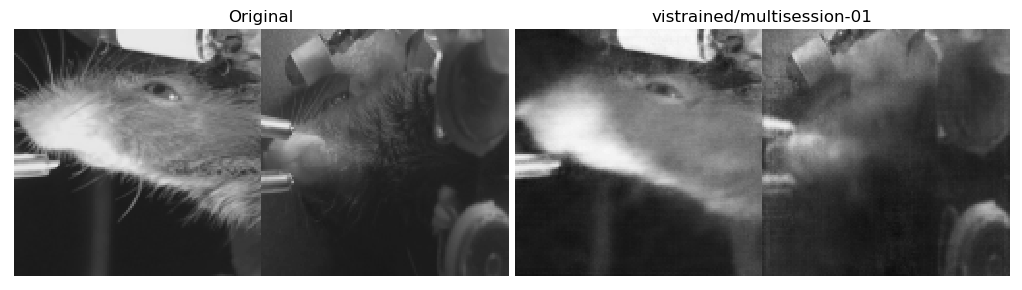

In [2]:
from behavenet.analyses.ae_utils import make_ae_reconstruction_movie_multisession
from behavenet.data.data_generator import ConcatSessionsGenerator

lab = 'musall'
version = 'best'
hparams = {
    'data_dir': '/home/mattw/data/',  # might be a different path than what is saved in hparams
    'tt_save_path': '/home/mattw/results/behavenet/',
    'experiment_name': 'test_pt_bn',
    'model_class': 'ae',
    'model_type': 'conv'}
get_lab_example(hparams, lab)
hparams['lab'] = lab
hparams['expt'] = 'vistrained'
hparams['animal'] = 'mSM34'
hparams['session'] = '02-Dec-2017'
   
data_generator = ConcatSessionsGenerator(
    hparams['data_dir'], hparams, 
    signals_list=[['images']], 
    transforms_list=[[None]], 
    paths_list=[[os.path.join(
        hparams['data_dir'], hparams['lab'], hparams['expt'], 
        hparams['animal'], hparams['session'], 'data.hdf5')]],
    device='cpu', as_numpy=False, batch_load=True, rng_seed=0)
trial = data_generator.datasets[0].batch_indxs['test'][4]
batch = data_generator.datasets[0][trial]['images'][:400]

save_file = os.path.join(
    results_dir, 
    str('%s_%02i-dim_%s_%s_bn' % 
        (hparams['lab'], hparams['n_ae_latents'], hparams['animal'], hparams['session'])))

# now define where the model comes from
# hparams['expt'] = 'vistrained'
# hparams['animal'] = 'all'
# hparams['session'] = ''
# hparams['multisession'] = 1         
# hparams['session_dir'], _ = get_output_session_dir(hparams) 

make_ae_reconstruction_movie_multisession(
    hparams, version=version, batch=batch, save_file=save_file, trial=trial)   